In [305]:
#получение обучающей, тестовой и тестовой выборки
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

dbname = 'football'
user = 'postgres'
password = 'TheDarkKhight'
host = 'localhost'
port = 5432

In [2]:
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)

In [3]:
sql_test_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'test'"
sql_valid_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'valid'"
sql_train_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'train'"
test_data = pd.read_sql_query(sql_test_data, conn)
valid_data = pd.read_sql_query(sql_valid_data, conn)
train_data = pd.read_sql_query(sql_train_data, conn)

C:\Users\arbol\AppData\Local\Temp\ipykernel_16708\466267492.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_data = pd.read_sql_query(sql_test_data, conn)
C:\Users\arbol\AppData\Local\Temp\ipykernel_16708\466267492.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  valid_data = pd.read_sql_query(sql_valid_data, conn)
C:\Users\arbol\AppData\Local\Temp\ipykernel_16708\466267492.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train_data = pd.read_sql_query(sql_train_data, conn)


In [4]:
conn.close()

In [5]:
match_data = pd.read_csv('match_data.csv',index_col='id')

In [40]:
def create_samples(data):
    y = []
    x = []
    for _, row in data.iterrows():
        new_line_home = []
        new_line_away = []
        home_team_data = match_data[(match_data['team_id'] == row['home_id']) & (match_data['time'] < row['time'])][-15::]
        away_team_data = match_data[(match_data['team_id'] == row['away_id']) & (match_data['time'] < row['time'])][-15::]
        hh = home_team_data[home_team_data['position'] == 'home']
        ha = home_team_data[home_team_data['position'] == 'away']

        ah = away_team_data[away_team_data['position'] == 'home']
        aa = away_team_data[away_team_data['position'] == 'away']

        new_line_home.extend([row['home_id'], row['time'], hh['goals'].mean(), ha['goals'].mean(), hh['shots'].mean(), ha['shots'].mean(), hh['xg'].mean(), ha['xg'].mean()])
        new_line_away.extend([row['away_id'], row['time'], ah['goals'].mean(), aa['goals'].mean(), ah['shots'].mean(), aa['shots'].mean(), ah['xg'].mean(), aa['xg'].mean()])

        x.extend([new_line_home, new_line_away]) 
        y.extend([[0.5, min(row['home_goals'], 4) if row['home_goals'] > 0 else 0], [1, min(row['away_goals'], 4) if row['away_goals'] > 0 else 0]])
        #y.extend([[1, row['home_goals']], [2, row['away_goals']]])
    return x, y

x_test, y_test = create_samples(test_data)
x_test = pd.DataFrame(x_test, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_test = pd.DataFrame(y_test, columns=['position', 'actual_goal'])

In [46]:
all_test = pd.concat([x_test, y_test], axis=1)
all_test_home = all_test[all_test['position'] == 0.5].reset_index(drop=True)
all_test_away = all_test[all_test['position'] == 1].reset_index(drop=True)
all_test_away

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,621,1689955200,1.666667,2.833333,3.666667,6.333333,1.666667,2.833333,1.0,3
1,555,1690020000,2.000000,1.571429,6.625000,4.571429,2.000000,1.571429,1.0,1
2,1080,1690122600,2.142857,1.750000,6.000000,3.500000,2.142857,1.750000,1.0,2
3,2006,1690131600,1.428571,1.750000,1.428571,1.750000,1.428571,1.750000,1.0,0
4,1993,1690131600,1.375000,1.000000,3.000000,2.857143,1.375000,1.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...
85,779,1696694400,1.875000,0.714286,4.625000,2.285714,1.728750,0.998571,1.0,2
86,65,1696696200,1.714286,1.250000,2.857143,3.250000,1.048571,0.941250,1.0,0
87,66,1696770000,2.714286,0.875000,5.142857,3.875000,1.977143,1.416250,1.0,1
88,1993,1696771800,1.000000,0.571429,3.750000,2.142857,1.196250,0.887143,1.0,0


In [8]:
all_test_away.corr()

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
team_id,1.000000,-0.234983,-0.319676,-0.215130,-0.516599,-0.249178,-0.338108,-0.165984,NaN,-0.274819
time,-0.234983,1.000000,0.030420,-0.151105,0.061874,-0.060818,0.023846,-0.130569,NaN,-0.047409
mean_goals_home,-0.319676,0.030420,1.000000,0.374199,0.512493,0.318301,0.772665,0.250235,NaN,0.159514
mean_goals_away,-0.215130,-0.151105,0.374199,1.000000,0.272999,0.623266,0.373214,0.879226,NaN,0.191243
shots_home,-0.516599,0.061874,0.512493,0.272999,1.000000,0.504430,0.685561,0.240892,NaN,0.259491
shots_away,-0.249178,-0.060818,0.318301,0.623266,0.504430,1.000000,0.420134,0.598137,NaN,0.199404
xg_home,-0.338108,0.023846,0.772665,0.373214,0.685561,0.420134,1.000000,0.350438,NaN,0.151683
xg_away,-0.165984,-0.130569,0.250235,0.879226,0.240892,0.598137,0.350438,1.000000,NaN,0.192570
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_goal,-0.274819,-0.047409,0.159514,0.191243,0.259491,0.199404,0.151683,0.192570,NaN,1.000000


In [47]:
x_valid, y_valid = create_samples(valid_data)

In [48]:
x_valid = pd.DataFrame(x_valid, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_valid = pd.DataFrame(y_valid, columns=['position', 'actual_goal'])
all_valid = pd.concat([x_valid, y_valid], axis=1)
all_valid_home = all_valid[all_valid['position'] == 0.5].reset_index(drop=True)
all_valid_away = all_valid[all_valid['position'] == 1].reset_index(drop=True)
all_valid_home

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,1080,1666965600,2.428571,1.000000,7.857143,5.000000,2.428571,1.000000,0.5,4
1,596,1667655000,4.285714,1.750000,9.714286,5.000000,4.285714,1.750000,0.5,1
2,555,1667664000,2.857143,1.125000,6.428571,3.625000,2.857143,1.125000,0.5,0
3,1079,1668250800,0.857143,1.125000,5.571429,5.000000,0.857143,1.125000,0.5,1
4,39,1668282300,0.750000,0.428571,3.250000,3.857143,0.750000,0.428571,0.5,0
...,...,...,...,...,...,...,...,...,...,...
85,596,1695562200,2.200000,1.700000,5.200000,3.100000,1.580000,1.361000,0.5,1
86,1993,1695657600,1.000000,0.555556,3.833333,2.333333,1.261667,0.801111,0.5,0
87,39,1696082400,1.285714,0.625000,4.285714,2.500000,1.110000,0.953750,0.5,2
88,1085,1696176000,2.000000,0.714286,4.500000,2.857143,2.322500,0.628571,0.5,1


In [251]:
all_valid_away.corr()

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
team_id,1.000000,0.013656,-0.097680,-0.093054,-0.156001,-0.010546,-0.119600,-0.216713,NaN,-0.157631
time,0.013656,1.000000,-0.051912,-0.061260,-0.171614,0.020929,-0.022182,0.013262,NaN,-0.112470
mean_goals_home,-0.097680,-0.051912,1.000000,0.477517,0.702599,0.419039,0.917077,0.443394,NaN,0.395888
mean_goals_away,-0.093054,-0.061260,0.477517,1.000000,0.288294,0.627332,0.437558,0.908590,NaN,0.130990
shots_home,-0.156001,-0.171614,0.702599,0.288294,1.000000,0.341031,0.801600,0.289838,NaN,0.344050
shots_away,-0.010546,0.020929,0.419039,0.627332,0.341031,1.000000,0.482525,0.625613,NaN,0.217270
xg_home,-0.119600,-0.022182,0.917077,0.437558,0.801600,0.482525,1.000000,0.456612,NaN,0.424479
xg_away,-0.216713,0.013262,0.443394,0.908590,0.289838,0.625613,0.456612,1.000000,NaN,0.187276
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_goal,-0.157631,-0.112470,0.395888,0.130990,0.344050,0.217270,0.424479,0.187276,NaN,1.000000


In [50]:
x_train, y_train = create_samples(train_data)
x_train = pd.DataFrame(x_train, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_train = pd.DataFrame(y_train, columns=['position', 'actual_goal'])
all_train = pd.concat([x_train, y_train], axis=1)
all_train_home = all_train[all_train['position'] == 0.5].reset_index(drop=True)
all_train_away = all_train[all_train['position'] == 1].reset_index(drop=True)
all_train_away

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,596,1665927000,3.833333,1.666667,9.166667,5.000000,3.833333,1.666667,1.0,3
1,558,1665939600,2.800000,2.142857,6.200000,7.000000,2.800000,2.142857,1.0,2
2,779,1666114200,1.875000,1.800000,5.000000,4.600000,1.875000,1.800000,1.0,1
3,1085,1666182600,1.166667,2.000000,5.000000,5.428571,1.166667,2.000000,1.0,2
4,558,1666191600,2.800000,2.125000,6.200000,6.625000,2.800000,2.125000,1.0,2
...,...,...,...,...,...,...,...,...,...,...
420,1079,1696762800,2.444444,1.500000,5.444444,3.833333,1.903333,1.883333,1.0,0
421,34,1696770000,1.888889,2.666667,6.444444,5.833333,2.497778,2.006667,1.0,2
422,40,1696770000,2.375000,2.285714,5.500000,4.571429,2.305000,2.042857,1.0,2
423,50,1696779000,2.285714,1.625000,4.714286,6.625000,1.818571,1.835000,1.0,0


In [322]:
def get_graphics_goals(y_test, y_pred, msg):
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(msg)
    plt.legend()
    plt.show()

In [323]:
def get_results_models(models, x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away):
    results_home = {}
    results_away = {}
    for model in models:
        model_name = model.__class__.__name__
        model.fit(x_train_home, y_train_home)
        y_pred_home = model.predict(x_valid_home)
        mse_home = np.sqrt(mean_squared_error(y_valid_home, y_pred_home))
        mae_home = mean_absolute_error(y_valid_home, y_pred_home)

        model.fit(x_train_away, y_train_away)
        y_pred_away = model.predict(x_valid_away)
        mse_away = np.sqrt(mean_squared_error(y_valid_away, y_pred_away))
        mae_away = mean_absolute_error(y_valid_away, y_pred_away)

        results_home[model_name] = {'RMSE': mse_home, 'MAE': mae_home, 'MIN': min(y_pred_home), 'MAX': max(y_pred_home)}
        results_away[model_name] = {'RMSE': mse_away, 'MAE': mae_away, 'MIN': min(y_pred_away), 'MAX': max(y_pred_away)}
    results_home = pd.DataFrame(results_home)
    results_away = pd.DataFrame(results_away)
 
    print('Метрики для домашнего прогноза:')
    print(results_home)
    get_graphics_goals(y_valid_home, y_pred_home, 'Полином')
    print('\nМетрики для гостевого прогноза:')
    get_graphics_goals(y_valid_away, y_pred_away, 'Полином')
    print(results_away)

In [374]:
def train_model(frames):
    # ------------ Получение x и y -----------------------------
    x_train_home = frames[0].drop(['team_id', 'time','position' ,'actual_goal', 'elo'], axis=1)
    y_train_home = frames[0]['actual_goal']
    x_train_away = frames[1].drop(['team_id', 'time','position' ,'actual_goal', 'elo'], axis=1)
    y_train_away = frames[1]['actual_goal']

    x_valid_home = frames[2].drop(['team_id', 'time','position', 'actual_goal', 'elo'], axis=1)
    y_valid_home = frames[2]['actual_goal']
    x_valid_away = frames[3].drop(['team_id', 'time','position', 'actual_goal', 'elo'], axis=1)
    y_valid_away = frames[3]['actual_goal']

    x_test_home = frames[4].drop(['team_id', 'time','position', 'actual_goal', 'elo'], axis=1)
    y_test_home = frames[4]['actual_goal']
    x_test_away = frames[5].drop(['team_id', 'time','position', 'actual_goal', 'elo'], axis=1)
    y_test_away = frames[5]['actual_goal']

    # ------------ Нормализация -----------------------------
    scaler = MinMaxScaler()
    x_train_home = scaler.fit_transform(x_train_home)
    x_train_away = scaler.fit_transform(x_train_away)
    x_valid_home = scaler.fit_transform(x_valid_home)
    x_valid_away = scaler.fit_transform(x_valid_away)
    x_test_home = scaler.fit_transform(x_test_home)
    x_test_away = scaler.fit_transform(x_test_away)

    # ------------ Прогнозирование (линейная регрессия, случайный лес, полином) -----------------------------
    models = [LinearRegression(), 
	          RandomForestRegressor(n_estimators=50, max_features ='sqrt'),
              make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=1.0))
	          ]
    get_results_models(models, x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away)
    
    # ------------ Прогнозирование (нейронная сеть) -----------------------------
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.regularizers import l2, l1
    from keras import backend as K

    def root_mean_squared_error(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
    input_shape = (7, )

    model_away = keras.Sequential([
        keras.layers.Dense(343, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(343, activation='linear'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(49, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(7, activation='relu'),
        keras.layers.Dense(1)
    ])

    model_home = keras.Sequential([
        keras.layers.Dense(343, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(343, activation='linear'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(49, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(7, activation='relu'),
        keras.layers.Dense(1)
    ])


    model_away.compile(optimizer='adam', loss='mean_squared_error')
    model_home.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping_home = keras.callbacks.EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)
    early_stopping_away = keras.callbacks.EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

    train_away = model_away.fit(x_train_away, y_train_away, epochs=1000, shuffle=True, validation_data=(x_valid_away, y_valid_away), callbacks=[early_stopping_away])
    train_home = model_home.fit(x_train_home, y_train_home, epochs=1000, shuffle=True, validation_data=(x_valid_home, y_valid_home), callbacks=[early_stopping_home])
    
    history = train_away.history
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # ------------ Результаты (нейронная сеть) -----------------------------
    test_loss_home = model_home.evaluate(x_valid_home, y_valid_home)
    y_pred_home = model_home.predict(x_valid_home)  
    print('Домашние прогнозы:')
    print(f"Test Loss (MAE): {test_loss_home}")
    #print(f"Test RMSE: {np.sqrt(test_loss_home)}")
    #print(f"Test MAE: {test_mae_home}")
    print(f"MIN: {min(y_pred_home)}")
    print(f"MAX: {max(y_pred_home)}")
    get_graphics_goals(y_valid_home, y_pred_home, 'Нейросеть (домашние матчи)')

    test_loss_away = model_away.evaluate(x_valid_away, y_valid_away)
    y_pred_away = model_away.predict(x_valid_away)  
    print('Гостевые прогнозы:')
    print(f"Test Loss (MAE): {test_loss_away}")
    #print(f"Test RMSE: {np.sqrt(test_loss_away)}")
   # print(f"Test MAE: {test_mae_away}")
    print(f"MIN: {min(y_pred_away)}")
    print(f"MAX: {max(y_pred_away)}")
    get_graphics_goals(y_valid_away, y_pred_away, 'Нейросеть (гостевые матчи)')

In [253]:
#2. Внедрение рейтинга ELO
#объединение файлов
elo_england_22 = pd.read_csv('./elo/csv/England/2022/ratingElo2022_2023PL.csv')
elo_england_23 = pd.read_csv('./elo/csv/England/2023/ratingElo2023_2024PL.csv')

elo_england_22.set_index('id', inplace=True)
elo_england_23.set_index('id', inplace=True)

elo_england_23['prev_elos'] = elo_england_23.apply(lambda row: elo_england_22.loc[row.name]['prev_elos'] + row['prev_elos'] if row.name in elo_england_22.index else row['prev_elos'], axis=1)
elo_england_23.reset_index(inplace=True)

elo_russian_22 = pd.read_csv('./elo/csv/Russia/2022/ratingElo2022_2023RFPL.csv')
elo_russian_23 = pd.read_csv('./elo/csv/Russia/2023/ratingElo2023_2024RFPL.csv')

elo_russian_22.set_index('id', inplace=True)
elo_russian_23.set_index('id', inplace=True)

elo_russian_23['prev_elos'] = elo_russian_23.apply(lambda row: elo_russian_22.loc[row.name]['prev_elos'] + row['prev_elos'] if row.name in elo_russian_22.index else row['prev_elos'], axis=1)
elo_russian_23.reset_index(inplace=True)
all_elo = pd.concat([elo_england_23, elo_russian_23])
all_elo.reset_index(inplace=True)

In [269]:
import re, json
def process_row(row):
    fixed_string = re.sub(r'\}\{', ',', all_elo[all_elo['id'] == row['team_id']]['prev_elos'].iloc[0])
    fixed_string = re.sub(r'(\d+)(?=:)', r'"\1"', fixed_string)
    json_string = json.loads(fixed_string)
    return json_string[f"{int(row['time'])}"]

In [273]:
def add_column_elo(frame):
    frame['elo'] = frame.apply(process_row, axis=1)

In [282]:
samples = [all_train_home, all_train_away, all_valid_home, all_valid_away, all_test_home, all_test_away]
for item in samples:
    add_column_elo(item)

In [288]:
all_train_home['diff_elo'] = all_train_home['elo'] - all_train_away['elo']
all_train_away['diff_elo'] = all_train_away['elo'] - all_train_home['elo']
all_valid_home['diff_elo'] = all_valid_home['elo'] - all_valid_away['elo']
all_valid_away['diff_elo'] = all_valid_away['elo'] - all_valid_home['elo']
all_test_home['diff_elo'] = all_test_home['elo'] - all_test_away['elo']
all_test_away['diff_elo'] = all_test_away['elo'] - all_test_home['elo']

Метрики для домашнего прогноза:
      LinearRegression  RandomForestRegressor  Pipeline
RMSE          1.125707               1.175462  1.140888
MAE           0.886164               0.970444  0.896263
MIN           0.505806               0.480000  0.679714
MAX           2.474869               2.680000  2.559962


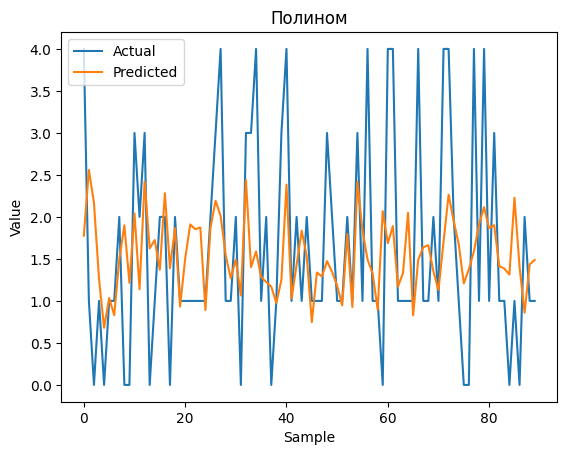


Метрики для гостевого прогноза:


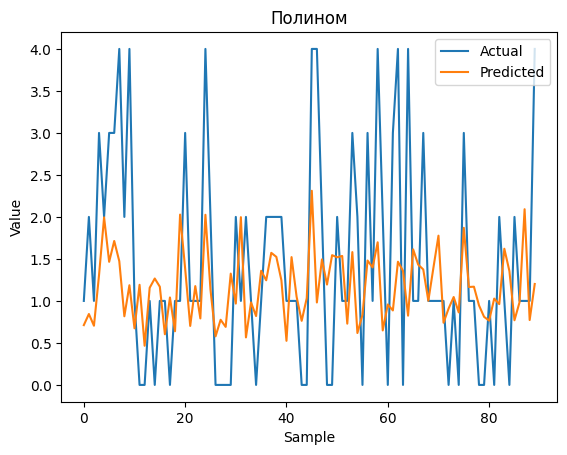

      LinearRegression  RandomForestRegressor  Pipeline
RMSE          1.202424               1.186846  1.188730
MAE           0.959721               0.947111  0.944194
MIN           0.074709               0.500000  0.466239
MAX           2.239176               2.600000  2.311228
Epoch 1/1000
14/14 [==============================] - 3s 31ms/step - loss: 2.6156 - val_loss: 2.6804
Epoch 2/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2406 - val_loss: 2.4802
Epoch 3/1000
14/14 [==============================] - 0s 13ms/step - loss: 2.1795 - val_loss: 2.3928
Epoch 4/1000
14/14 [==============================] - 0s 13ms/step - loss: 2.0935 - val_loss: 2.3258
Epoch 5/1000
14/14 [==============================] - 0s 13ms/step - loss: 2.0270 - val_loss: 2.2564
Epoch 6/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.0425 - val_loss: 2.4205
Epoch 7/1000
14/14 [==============================] - 0s 15ms/step - loss: 2.0158 - val_loss: 2.1830
Epoch 8/1000


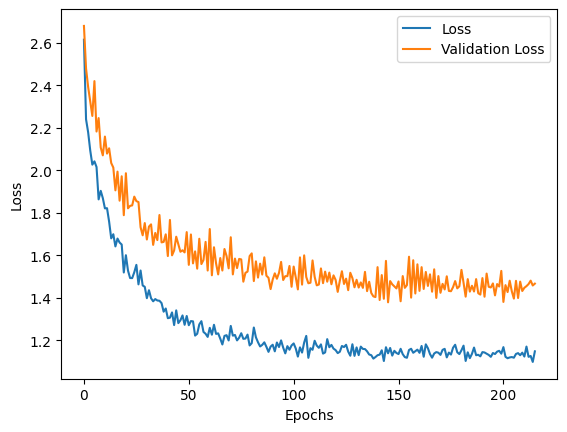

3/3 [==============================] - 0s 0s/step
Домашние прогнозы:
Test Loss (MAE): 1.3080337047576904
MIN: [0.81822646]
MAX: [2.6322167]


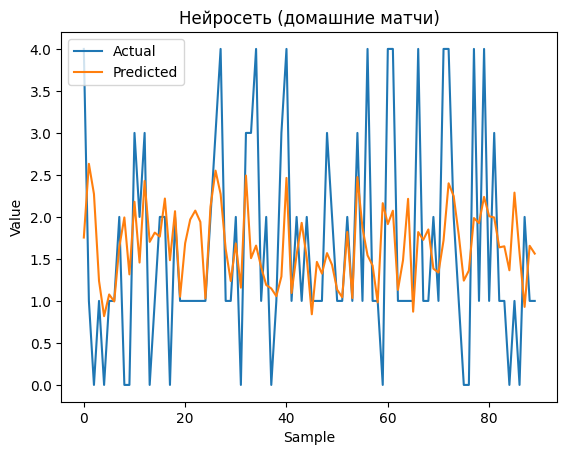

3/3 [==============================] - 0s 8ms/step
Гостевые прогнозы:
Test Loss (MAE): 1.378531575202942
MIN: [0.5875597]
MAX: [2.4884872]


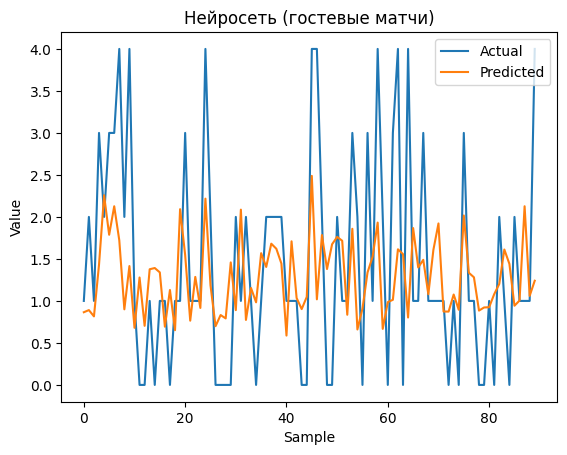

In [375]:
train_model(samples)